# Analyze A/B Test Results For an E-commerce Website 

The current notebook is organized into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

<a id='intro'></a>
## Introduction

In this project an A/B test is run for an e-commerce website to help understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.


<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [6]:
# The Number of rows in data 
df.shape[0]

294478

In [7]:
# The number of unique users in the dataset.
df.user_id.nunique()

290584

In [8]:
# The proportion of users converted.
df.converted.mean()

0.11965919355605512

In [9]:
# The number of times when the "group" is treatment but "landing_page" is not a new_page.
df.query('group=="treatment" and landing_page == "old_page"').shape[0]

1965

In [10]:
# Checking for missing values
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

The control group users should match with old_page; and treatment group users should matched with the new_page. However, for the rows where treatment does not match with new_page or control does not match with old_page, we cannot be sure if such rows truly received the new or old wepage.

In [13]:
# Removeing the inaccurate rows, and storeing the result in a new dataframe df2
df2 = df
inaccurate1 = df.query('group=="treatment" and landing_page == "old_page"')
inaccurate2 = df.query('group=="control" and landing_page == "new_page"')
df2 = df2.drop(inaccurate1.index)
df2 = df2.drop(inaccurate2.index)

In [14]:
# Double Check all of the incorrect rows were removed from df2 
# Output of the statement below should be 0 
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [15]:
# How many unique user_ids?
df2.user_id.nunique()

290584

In [16]:
# Number of Dublicated User_ids
df2.duplicated(subset=['user_id']).sum()

1

In [17]:
# Displaying the rows for the duplicate user_id
duplicated_row = df2[df2.duplicated(subset=['user_id'])]
duplicated_row

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [18]:
# Removeing the duplicated user_id.
df2.drop(duplicated_row.index, inplace= True)
# Check again if the row with a duplicate user_id is deleted or not
df2.duplicated(subset=['user_id']).sum()

0

In [19]:
# Probability of an individual converting regardless of the page they receive
Ppopulation = df2.converted.mean()
Ppopulation

0.11959708724499628

In [20]:
# Probability of convertetion in control group
contolr_cr = df2.query('group =="control"').converted.mean()
contolr_cr

0.1203863045004612

In [21]:
# Probability of convertetion in treatment group
treatment_cr = df2.query('group =="treatment"').converted.mean()
treatment_cr

0.11880806551510564

In [22]:
# Calculating the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = treatment_cr - contolr_cr
obs_diff

-0.0015782389853555567

In [23]:
#  The probability that an individual received the new page
df2.landing_page.value_counts(normalize=True)[0]

0.5000619442226688

>**The probilities of indviduals getting Nnwe page and Nold page are equal, However the conversion rate when using the nwe page is less than the converstion rate when using the old one  .**

<a id='ab_test'></a>
## Part II - A/B Test

Assuming that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, the null and alternative hypotheses are:

$$H_0: p_{new} - p_{old} <= 0  $$

$$H_1: p_{new} - p_{old} > 0 $$


Under the null hypothesis $H_0$, We can assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, we can assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

We will do the follwoing: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 

In [29]:
# the conversion rate for  𝑝𝑛𝑒𝑤  under the null hypothesis
p_new= df2.converted.mean()
p_new

0.11959708724499628

In [30]:
# the conversion rate for  𝑝old  under the null hypothesis
p_old = df2.converted.mean()
p_old

0.11959708724499628

In [31]:
# N𝑛𝑒𝑤, the number of individuals in the treatment group
n_new = df2.query('group == "treatment"').user_id.count()
n_new

145310

In [32]:
# Nold, the number of individuals in the control group
n_old = df2.query('group == "control"').user_id.count()
n_old

145274

In [33]:
# Simulate a Sample for the treatment Group
df_treatment = df2.query('group == "treatment"')
bs_tratment = df_treatment.sample(n_new, replace = True)
new_page_converted = bs_tratment.converted.mean()
new_page_converted

0.11714266051889065

In [34]:
# Simulate a Sample for the control Group
df_control = df2.query('group == "control"')
bs_control = df_control.sample(n_old, replace = True)
old_page_converted = bs_control.converted.mean()
old_page_converted

0.11977366906672908

In [36]:
# the difference in the "converted" probability between simulated samples
new_page_converted - old_page_converted 

-0.0026310085478384315

In [37]:
# Sampling distribution 
p_diffs = []
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

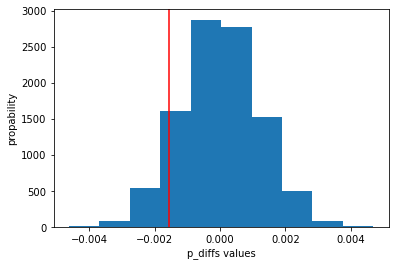

In [38]:
# Plotting a histogram of the p_diffs
plt.hist(p_diffs)
plt.axvline(obs_diff, c='red')
plt.xlabel('p_diffs values')
plt.ylabel('propability');

In [40]:
# P-value
(p_diffs > obs_diff).mean()

0.9048

>**P value represents the Proportion of the p_diffs that greater than the actual difference observed in the df2. It is greater than the significance level(0.05) so we fail to reject the null hypothesis**

---
### About the two-sample z-test
Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test** that calculates the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. 
><br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 


In other words, we determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. A "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.



Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples)

In [41]:
# Using Built-in Methods for Hypothesis Testing (two-sample z-test) to calculate the z_score, p_value
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('group == "control"').converted.mean()

# number of conversions with the new_page
convert_new = df2.query('group == "treatment"').converted.mean()

# number of individuals who were shown the old_page
n_old = df2.query('group == "control"').user_id.count()

# number of individuals who received new_page
n_new = df2.query('group == "treatment"').user_id.count()

In [30]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
count = [convert_old, convert_new]
nobs = [n_old, n_new]
z_score, p_value = sm.stats.proportions_ztest(np.array(count), np.array(nobs), alternative='larger')
print(z_score, p_value)

0.0032875796753531767 0.49868844782989563


>**Z-score is a numerical measurement that describes a value's relationship to the mean of a group of values. Z-score is measured in terms of standard deviations from the mean, here Z-score is lower than Z-alpha, we fail to reject null hypothesis. .**

<a id='regression'></a>
### Part III - A Logisitc regression approach
The result that achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

In [42]:
# Instantiate dummy variables for the group column 
df2['intercept'] = 1
dummies = pd.get_dummies(df2[['group']])
dummies = dummies.drop('group_control', axis =1)
df2['ab_page'] = dummies
df2.shape

(290584, 7)

In [43]:
# Istantiate the regression model 
import statsmodels.api as sm;
lm = sm.Logit(df2['converted'], df2[['intercept','ab_page']])

In [44]:
# Summary 
lm.fit().summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 11 Oct 2021   Pseudo R-squ.:               8.077e-06
Time:                        13:00:23   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

>**P value associated to ab_page is equale to 0.190, it is greater than the significance level, ab_page is not statsticaly significant, it differs from that clculated in part 2 because the null hypothesis in part 2 is one sided, but null hypothesis in part 3 is two sided**

>**R-squared value is so small and ab_page only has no significane, more factors like countries should be considered to make a multiple regression model.**

In [45]:
# Read the countries.csv
countries = pd.read_csv('countries.csv')

In [46]:
# Join with the df2 dataframe
df_merged = df2.merge(countries, on= 'user_id')

In [47]:
# Create the necessary dummy variables
dummies = pd.get_dummies(df_merged[['country']])
dummies = dummies.drop('country_CA', axis =1)
df_merged[['UK', 'US']] = dummies
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1


In [48]:
# Fit your model, and summarize the results
lm = sm.Logit(df_merged['converted'], df_merged[['intercept','ab_page', 'UK' ,'US']])
lm.fit().summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Oct 2021   Pseudo R-squ.:               2.323e-05
Time:                        13:02:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

>**Both Page and country have no statstical significane on conversion, We will examine adding interaction terms**

In [49]:
# Fit your model, and summarize the results
df_merged['ab_UK'] = df_merged['ab_page'] * df_merged['UK']
df_merged['ab_US'] = df_merged['ab_page'] * df_merged['US']
lm = sm.Logit(df_merged['converted'], df_merged[['intercept','ab_page','ab_UK' ,'ab_US','UK' ,'US']])
lm.fit().summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 11 Oct 2021   Pseudo R-squ.:               3.482e-05
Time:                        13:05:20   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
ab_UK          0.0783      0.057      1.378      0.168      -0.033       0.190
ab_US          0.0469      0.054      0.872      0.383      -0.059       0.152
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
==============================================================================
"""

>**Both Page and the interaction term between page and countries have no statstical significane on conversion, practicaly it is not recomended to implement the new landing page because this will take time and money and conversion will be lower!**